# Amazon food review dataset apply knn to predict polarity review

Data set from https://www.kaggle.com/snap/amazon-fine-food-reviews

# Objective
Here try BOW,TFIDF,avg W2V, avg TFIDFW2V and split train test 70-30 10fold cross validation and find optimal k
report test accuracy. Use brute force and kd-tree for building knn.

# Import data and libraries
 
 

In [1]:
from sklearn.manifold import TSNE
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

con = sqlite3.connect('database.sqlite') 

#get only +ve and -ve review 
raw_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

# Data preprocessing

In [2]:
filtered_data=raw_data
# Score>3 a positive rating, and score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

filtered_data.sample(5)
filtered_data['Score'].value_counts()

#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries for same profilename,userid, time, text and take first element 
sorted_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)


In [44]:
#take only 5000 + 5000 data
clean_data=sorted_data.sample(frac=1).groupby('Score').head(5000)
clean_data['Score'].value_counts()

positive    5000
negative    5000
Name: Score, dtype: int64

In [45]:
# Clean html tag and punctuation

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

#substitute html tag and punctuation
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
#print(sno.stem('tasty'))

In [46]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
#Create new catagory as Cleanedtext after removing htmltag and punctuation and uppercase and word length >2
for sent in clean_data['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (clean_data['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(clean_data['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i+=1
    

In [47]:
clean_data['CleanedText']=final_string
#store for future use
#conn = sqlite3.connect('clean_data.sqlite')
#c=conn.cursor()
#conn.text_factory = str
#clean_data.to_sql('Reviews1', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)
#con = sqlite3.connect('clean_data.sqlite') 
#clean_data = pd.read_sql_query("""SELECT * FROM Reviews1 WHERE Score != 3""", con) 
#clean_data['CleanedText'].sample(15)
clean_data.shape
#Sort data on timestamp
clean_data=clean_data.sort_values(by=['Time'],ascending=False)
#clean_data
clean_data.sample(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
237501,257668,B003LJB8C6,A3JH9ICLEYSESN,David,3,3,positive,1327363200,Excellent Asian Formulation of Milo,This product is made in Malaysia and is the sa...,b'product made malaysia exact product would bu...
377514,408224,B003VWBZJO,A3U73Z1BCQMDXV,"James E. Langsford ""I love music!""",1,1,positive,1314835200,Dog treats,I bought the Sweet Potato Chicken Jerky Twists...,b'bought sweet potato chicken jerki twist dog ...
385644,417006,B0026VM19Y,AW46UWA0D6YH,Katherine Thomas,2,3,positive,1266883200,Surprisingly good!!,"A great addition to a shake, and is wonderful ...",b'great addit shake wonder top jello'
82694,90006,B0046GRD0O,A1QG2M87WNG28D,Anne in Florida,4,4,positive,1345161600,Cacao BLISS indeed!,Holy moly this stuff is delicious! I am a tot...,b'holi moli stuff delici total sucker anyth ch...
10970,11967,B001P1V2UK,AV43UL9S8TUK8,Andrew D. Frost,0,0,negative,1322438400,Not a genuine Terrafina product,I purchased this product from Otto's because t...,b'purchas product otto offer via amazon prime ...


# Model using BOW knn

In [48]:
#now convert CleanedText to TDM
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(clean_data['CleanedText'].values)
print(final_counts.get_shape())
print(type(final_counts))
#print(final_counts[[1]])
#print(final_counts[0,:])# this is stored like dict format only non zero values. sparse matrix
#x = pd.DataFrame(final_counts.toarray())#this is stored like dataframe format all 0 and non zero values. dense matrix
# sparse matrix in csr format works faster compare to dense format
#print(x.shape,x.loc[0])

(10000, 13326)
<class 'scipy.sparse.csr.csr_matrix'>


In [49]:
#x = pd.DataFrame(final_counts.toarray())
x=final_counts
y = clean_data['Score']
#time=time.reset_index(drop=True)
n=x.shape[0]
n1=int(n*.3)
#X_test = x[0:n1]
#X_train= x[n1:n+1]

X_test = x[0:n1,:]
X_train= x[n1:n+1,:]
y_test=y[0:n1]
y_train=y[n1:n+1]
print('size of X_train, X_test, y_train , y_test ',X_train.shape, X_test.shape,y_train.shape,y_test.shape)
print("positive and negative review in train and test\n",y_train.value_counts(),"\n",y_test.value_counts())

size of X_train, X_test, y_train , y_test  (7000, 13326) (3000, 13326) (7000,) (3000,)
positive and negative review in train and test
 positive    3582
negative    3418
Name: Score, dtype: int64 
 negative    1582
positive    1418
Name: Score, dtype: int64


In [50]:
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

In [51]:
# Create 10 fold cross validation
myList = list(range(0,10))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
  
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors and misclassification error using brute is',optimal_k,MSE.index(min(MSE)))


The optimal number of neighbors and misclassification error using brute is 9 4


In [52]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier using brute for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier using brute for k = 9 is 69.066667%


In [53]:
#ignore warning
import warnings
warnings.filterwarnings('ignore')
    
    # Use KDtree
# Create 10 fold cross validation
myList = list(range(0,10))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
cv_scores = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# changing to misclassification error
MSE = [1 - x for x in cv_scores]
# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors and misclassification error using kd-tree is',optimal_k,MSE.index(min(MSE)))  

# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier using kd-tree for k = %d is %f%%' % (optimal_k, acc)) 



The optimal number of neighbors and misclassification error using kd-tree is 9 4

The accuracy of the knn classifier using kd-tree for k = 9 is 69.066667%


# plot accuracy with k 

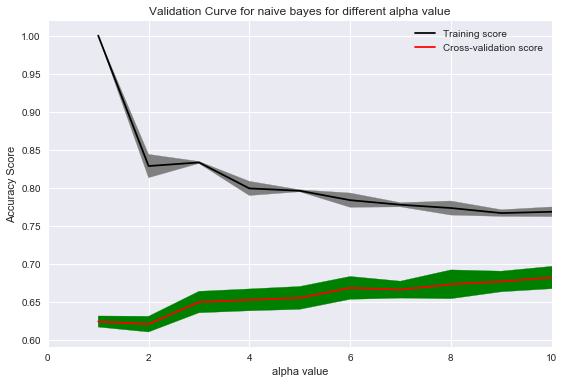

In [54]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import validation_curve
#create plot for training and test validation
# We cannot put 0 in parameter it will give error while validation_curve
n_neighbors=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
param_range=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

train_scores, test_scores = validation_curve(KNeighborsClassifier(), X_train, y_train, param_name="n_neighbors",param_range=n_neighbors,cv=5)
#print(train_scores,test_scores)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve for naive bayes for different alpha value")
plt.xlabel("alpha value")
plt.ylabel("Accuracy Score")
plt.xlim(0,20)
plt.tight_layout()
plt.legend(loc="best")
plt.show()


# Model using TFIDF


In [55]:
#now convert CleanedText to TDM
tf_idf_vect = TfidfVectorizer()
final_counts = tf_idf_vect.fit_transform(clean_data['CleanedText'].values)
#x = pd.DataFrame(final_counts.toarray())

In [56]:
#x = pd.DataFrame(final_counts.toarray())
x=final_counts
y = clean_data['Score']
#time=time.reset_index(drop=True)
n=x.shape[0]
n1=int(n*.3)
#X_test = x[0:n1]
#X_train= x[n1:n+1]
X_test = x[0:n1,:]
X_train= x[n1:n+1,:]


y_test=y[0:n1]
y_train=y[n1:n+1]
print('size of train, test, X , y ',X_train.shape, X_test.shape,y_train.shape,y_test.shape)


size of train, test, X , y  (7000, 13326) (3000, 13326) (7000,) (3000,)


In [57]:
# Create 10 fold cross validation
myList = list(range(0,10))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
  
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors and misclassification error using kd-tree is',optimal_k,MSE.index(min(MSE)))


The optimal number of neighbors and misclassification error using kd-tree is 9 4


In [58]:
#ignore warning
import warnings
warnings.filterwarnings('ignore')

# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier using kd-tree for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier using kd-tree for k = 9 is 68.366667%


In [59]:
#ignore warning
import warnings
warnings.filterwarnings('ignore')

# Use brute
# Create 10 fold cross validation
myList = list(range(0,10))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
cv_scores = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# changing to misclassification error
MSE = [1 - x for x in cv_scores]
# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors and misclassification error using brute is',optimal_k,MSE.index(min(MSE)))  

# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier using brute for k = %d is %f%%' % (optimal_k, acc))  


The optimal number of neighbors and misclassification error using brute is 9 4

The accuracy of the knn classifier using brute for k = 9 is 68.366667%


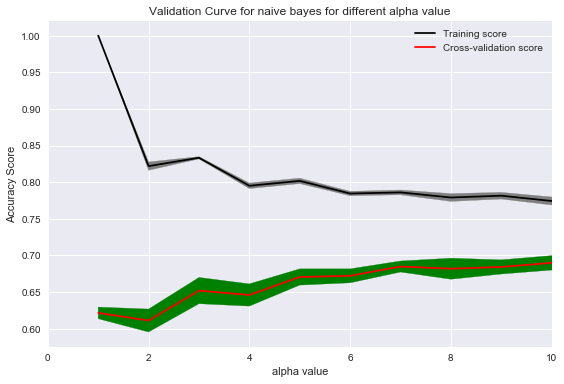

In [60]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import validation_curve
#create plot for training and test validation
# We cannot put 0 in parameter it will give error while validation_curve
n_neighbors=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
param_range=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

train_scores, test_scores = validation_curve(KNeighborsClassifier(), X_train, y_train, param_name="n_neighbors",param_range=n_neighbors,cv=5)
#print(train_scores,test_scores)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve for naive bayes for different alpha value")
plt.xlabel("alpha value")
plt.ylabel("Accuracy Score")
plt.xlim(0,20)
plt.tight_layout()
plt.legend(loc="best")
plt.show()


# Build model using avg W2V

In [61]:
#ignore warning
import warnings
warnings.filterwarnings('ignore')


from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
import gensim
i=0
#create a list of list to be used in W2V 
list_of_sent=[]
for sent in clean_data['CleanedText'].values:
    filtered_sentence=[]
    #sent=cleanhtml(sent)
    for w in sent.split():
        #for cleaned_words in cleanpunc(w).split():
         for cleaned_words in w.split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower().decode('utf8'))
            else:
                continue 
    list_of_sent.append(filtered_sentence)
#convert each sentence's words to a vector of 50 dimension. Dont construct vec if word doesnot occur 5 times. And for each word construct 50 dimension vector
#and 4 core processor
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)   

# average Word2Vec
# for each sentence make average of vectors by (vectors of each words)/(total no of words)
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)  

#Sent_vectors ready for tsne   



In [62]:
#ignore warning
import warnings
warnings.filterwarnings('ignore')

x = pd.DataFrame(sent_vectors)
y = clean_data['Score']
#time=time.reset_index(drop=True)
n=x.shape[0]
n1=int(n*.3)
X_test = x[0:n1]
X_train= x[n1:n+1]
y_test=y[0:n1]
y_train=y[n1:n+1]
print('train and test X y',X_train.shape,X_test.shape,y_train.shape,y_test.shape)




# Create 10 fold cross validation
myList = list(range(0,10))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
  
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors and misclassification error usinf kd-tree is',optimal_k,MSE.index(min(MSE)))


# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier using kd-tree for k = %d is %f%%' % (optimal_k, acc))


# Use brute
# Create 10 fold cross validation
myList = list(range(0,10))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
cv_scores = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# changing to misclassification error
MSE = [1 - x for x in cv_scores]
# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors and misclassification error using brute  is',optimal_k,MSE.index(min(MSE)))  

# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier using brute for k = %d is %f%%' % (optimal_k, acc))
  

train and test X y (7000, 50) (3000, 50) (7000,) (3000,)

The optimal number of neighbors and misclassification error usinf kd-tree is 9 4

The accuracy of the knn classifier using kd-tree for k = 9 is 71.666667%

The optimal number of neighbors and misclassification error using brute  is 9 4

The accuracy of the knn classifier using brute for k = 9 is 71.666667%


#plot accuracy with k value

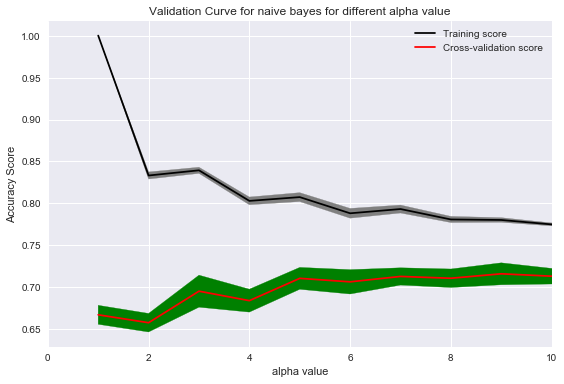

In [63]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import validation_curve
#create plot for training and test validation
# We cannot put 0 in parameter it will give error while validation_curve
n_neighbors=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
param_range=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

train_scores, test_scores = validation_curve(KNeighborsClassifier(), X_train, y_train, param_name="n_neighbors",param_range=n_neighbors,cv=5)
#print(train_scores,test_scores)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve for naive bayes for different alpha value")
plt.xlabel("alpha value")
plt.ylabel("Accuracy Score")
plt.xlim(0,20)
plt.tight_layout()
plt.legend(loc="best")
plt.show()


# Build model using avg tfidf w2v

In [64]:
#ignore warning
import warnings
warnings.filterwarnings('ignore')


# TF-IDF weighted Word2Vec
tf_idf_vect = TfidfVectorizer()
final_tf_idf=tf_idf_vect.fit_transform(clean_data['CleanedText'].values)
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
#calculate avg tfidf score for each sentences 
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]#calculate w2v for each word
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]#get tfidf score of each word 
            sent_vec += (vec * tf_idf) # multiply vec with tfidf of each word and cumulative add of words in each sentence
            weight_sum += tf_idf # also add tfidf sums in each sentence
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
#tfidf_sent_vectors.


x=tfidf_sent_vectors
y = clean_data['Score']
#time=time.reset_index(drop=True)
n=len(x)
n1=int(n*.3)
X_test = x[0:n1]
X_train= x[n1:n+1]
y_test=y[0:n1]
y_train=y[n1:n+1]
print('X y train test ',len(X_train),len(X_test),y_train.shape,y_test.shape)




# Create 10 fold cross validation
myList = list(range(0,10))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
  
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors and misclassification error using kd-tree is',optimal_k,MSE.index(min(MSE)))


# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier using kd-tree for k = %d is %f%%' % (optimal_k, acc))

# Use brute
# Create 10 fold cross validation
myList = list(range(0,10))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
cv_scores = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# changing to misclassification error
MSE = [1 - x for x in cv_scores]
# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors and misclassification error using brute  is',optimal_k,MSE.index(min(MSE)))  

# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier using brute for k = %d is %f%%' % (optimal_k, acc))
  

X y train test  7000 3000 (7000,) (3000,)

The optimal number of neighbors and misclassification error using kd-tree is 9 4

The accuracy of the knn classifier using kd-tree for k = 9 is 68.266667%

The optimal number of neighbors and misclassification error using brute  is 9 4

The accuracy of the knn classifier using brute for k = 9 is 68.266667%


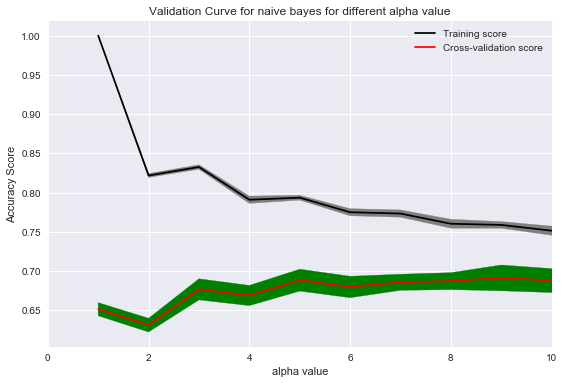

In [65]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import validation_curve
#create plot for training and test validation
# We cannot put 0 in parameter it will give error while validation_curve
n_neighbors=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
param_range=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

train_scores, test_scores = validation_curve(KNeighborsClassifier(), X_train, y_train, param_name="n_neighbors",param_range=n_neighbors,cv=5)
#print(train_scores,test_scores)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve for naive bayes for different alpha value")
plt.xlabel("alpha value")
plt.ylabel("Accuracy Score")
plt.xlim(0,20)
plt.tight_layout()
plt.legend(loc="best")
plt.show()


# Here is the performance accuracy
The knn is very slow compare to other model

For BOW brute/kd-tree k=9 69

TFIDF kd-tree/brute with k=9 and 68

sentence avg W2V kd-tree/brute k=9 71

sentence avg tfidf kd-tree/brute w2v k=9 68

So best is with W2V avg sentence with accuracy 71% and k=9